# Chapter 11. 나이브 베이지안 분류기
## 3. 나이브 베이지안 분류기 구현하기
### 01 - 나이브 베이지안 분류기 만들기
- 베이즈 분류기와의 차이점
    - 베이즈 분류기는 하나의 변수만을 고려
    - 나이브 베이지안 분류기는 여러 개의 열을 사용하여 분류기를 구성

In [31]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

data_url = "C:/Machine_Learning (git)/chapter11/fraud.csv"
df = pd.read_csv(data_url, sep = ',')
df.head()

,ID,History,CoApplicant,Accommodation,Fraud
0,1,current,none,own,True
1,2,paid,none,own,False
2,3,paid,none,own,False
3,4,paid,guarantor,rent,True
4,5,arrears,none,own,False


- 데이터를 보면 기본적으로 3개의 카테고리 피쳐(feature)인 **History, CoApplicant, Accommodation**이 있음
    - 이를 바탕으로 대출 사기 여부를 나타내는 이진값으로 **Fraud**가 존재

- 연산의 편의를 위해 먼저 **Y**값을 따로 빼내고, **get_dummies**를 활용하여 **X** 데이터들을 원핫인코딩으로 처리

In [32]:
del df["ID"]
Y_data = df.pop("Fraud")
Y_data = Y_data.values
x_df = pd.get_dummies(df)
x_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
History_arrears,False,False,False,False,True,True,False,True,False,False
History_current,True,False,False,False,False,False,True,False,True,False
History_none,False,False,False,False,False,False,False,False,False,True
History_paid,False,True,True,True,False,False,False,False,False,False
CoApplicant_coapplicant,False,False,False,False,False,False,False,False,False,False
CoApplicant_guarantor,False,False,False,True,False,False,False,False,False,False
CoApplicant_none,True,True,True,False,True,True,True,True,True,True
Accommodation_free,False,False,False,False,False,False,False,False,False,False
Accommodation_own,True,True,True,False,True,True,True,True,False,True
Accommodation_rent,False,False,False,True,False,False,False,False,True,False


In [24]:
# 해당 데이터를 넘파이 배열 형태로 저장
x_data = x_df.values
x_data

array([[False,  True, False, False, False, False,  True, False,  True,
        False],
       [False, False, False,  True, False, False,  True, False,  True,
        False],
       [False, False, False,  True, False, False,  True, False,  True,
        False],
       [False, False, False,  True, False,  True, False, False, False,
         True],
       [ True, False, False, False, False, False,  True, False,  True,
        False],
       [ True, False, False, False, False, False,  True, False,  True,
        False],
       [False,  True, False, False, False, False,  True, False,  True,
        False],
       [ True, False, False, False, False, False,  True, False,  True,
        False],
       [False,  True, False, False, False, False,  True, False, False,
         True],
       [False, False,  True, False, False, False,  True, False,  True,
        False],
       [False,  True, False, False,  True, False, False, False,  True,
        False],
       [False,  True, False, False, False, 

- 다음에 제시된 나이브 베이지안의 수식을 살펴봄
    - $P(Y_c|X_1, \dots , X_n) = \frac{P(Y_c)\displaystyle\Pi_{i = 1}^n P(X_i|Y_c)}{\displaystyle\Pi_{i = 1}^n P(X_i)} Y_c\;is\;a\;label$

- 이 수식을 코드로 표현하면 아래와 같음

In [25]:
P_Y_True = sum(Y_data == True) / len(Y_data)
P_Y_False = 1 - P_Y_True

P_Y_True, P_Y_False

(0.3, 0.7)

- $P(X_i|Y_c)$를 표현하기 위해 $Y_c$의 라벨을 기반으로 한 값을 출력하고자 함
    - 이를 위해 np.where 함수 사용
        - 특정 조건을 만족하는 값의 인덱스를 반환하는 함수

In [26]:
np.where(Y_data)

(array([ 0,  3,  5,  9, 11, 12], dtype=int64),)

In [27]:
# P(Y_True), P(Y_False)의 인덱스 값 정리
ix_Y_True = np.where(Y_data)
ix_Y_False = np.where(Y_data == False)

ix_Y_True, ix_Y_False

((array([ 0,  3,  5,  9, 11, 12], dtype=int64),),
 (array([ 1,  2,  4,  6,  7,  8, 10, 13, 14, 15, 16, 17, 18, 19],
        dtype=int64),))

- 다음 수식을 이용하여 해당 인덱스에 존재하는 **x_data**값을 찾아 적용시킴
    - $\log \{P(Y_c) \displaystyle\Pi_{i = 1}^n P(X_i|Y_c)\} = \log P(Y_c) + \displaystyle\sum_{i = 1}^n \log P(X_i|Y_c)$

- 이 때 $P(X_i|Y_{True})$값을 정의하기 위한 코드는 다음과 같음

In [33]:
p_x_y_true = (x_data[ix_Y_True].sum(axis= 0)) / sum(Y_data == True)
p_x_y_false = (x_data[ix_Y_False].sum(axis= 0)) / sum(Y_data == False)

p_x_y_true, p_x_y_false

(array([0.16666667, 0.5       , 0.16666667, 0.16666667, 0.        ,
        0.16666667, 0.83333333, 0.        , 0.66666667, 0.33333333]),
 array([0.42857143, 0.28571429, 0.        , 0.28571429, 0.14285714,
        0.        , 0.85714286, 0.07142857, 0.78571429, 0.14285714]))

In [34]:
# 최종적으로 X_n의 데이터를 가지고 있다고 가정할 때 해당 X_n의 값을 코드로 나타내면 아래와 같음
    # 여기서는 np.log 함수를 따로 붙여주지 않고 단순 덧셈 계산만 함

x_test = [0, 1, 0, 0, 0, 1, 0, 0, 1, 0]

p_y_true_test = P_Y_True + p_x_y_true.dot(x_test)
p_y_false_test = P_Y_False + p_x_y_false.dot(x_test)

p_y_true_test, p_y_false_test

(1.6333333333333333, 1.7714285714285714)

In [35]:
p_y_true_test < p_y_false_test

True

### 02 - 사이킷런을 활용한 나이브 베이지안 분류기

- 앞에서는 다소 복잡한 과정을 통해 직접 이진 나이브 베이지안 분류기를 구현
    - 그런데 현실에선 다양한 데이터가 있기 때문에 이를 대비하기 위해 사이킷런의 다양한 클래스들을 사용

- 하나의 문장이 있을 때 이 문장을 sports와 not sports로 나누는 분류기 만들기

In [38]:
y_example_text = ["Sports", "Not sports", "Sports", "Sports", "Not sports"]
y_example = [1 if c == "Sports" else 0 for c in y_example_text]
text_example = ["A great game game", "The The election was over",
                "Very clean game match", "A clean but forgettable game game",
                "It was a close election",]

- 이러한 텍스트 데이터에 대해서는 먼저 텍스트 데이터를 벡터 형태로 표현해야 함
    - 텍스트를 벡터화시키기 위해선 다양한 기법들이 있음
        - 여기서는 간단한 BoW(Bag of Words)기반의 벡터화를 진행

- BoW는 사이킷런에서 **CountVectorizer**라는 클래스로 지원
    - 사용법이 완전히 동일

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

countvect_example = CountVectorizer()
X_example = countvect_example.fit_transform(text_example)
countvect_example.get_feature_names_out()
# CountVectorizer는 기본적으로 BoW 벡터를 생성하기 위한 클래스
    # 여기에 fit_transform을 적용
        # 다른 사이킷런의 클래스들과 같이 fit을 통해 기본규칙을 세움
        # transform을 통해 원하는 벡터를 생성할 수 있음
# fit을 진행할 때는 처리해야 하는 단어들을 정의함
# get_feature_names_out 함수의 결과로 처리해야 하는 단어들의 모음을 보여줌
    # 이 단어들은 text_example 객체에 존재하는 단어들의 모음

array(['but', 'clean', 'close', 'election', 'forgettable', 'game',
       'great', 'it', 'match', 'over', 'the', 'very', 'was'], dtype=object)

In [43]:
countvect_example.transform(text_example).toarray()
# 위처럼 ㄱ칙을 세운 후 transform 함수를 적용시켜 array 배열 생성

array([[0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]], dtype=int64)

In [44]:
countvect_example.vocabulary_

{'great': 6,
 'game': 5,
 'the': 10,
 'election': 3,
 'was': 12,
 'over': 9,
 'very': 11,
 'clean': 1,
 'match': 8,
 'but': 0,
 'forgettable': 4,
 'it': 7,
 'close': 2}

#### 2.1 베르누이 나이브 베이지안 분류기

- 다양한 나이브 베이지안 분류기 중 하나를 선택하여 분류 작업을 실행할 수 있음
- 앞서 다룬 로지스틱 회귀에 비해 사이킷런의 분류기들은 비교적 단순히 구현 가능

- 베르누이 나이브 베이지안 분류기(BernoulliNB, 이하 베르누이 분류기)
    - 기본적으로 다루고자 하는 모든 데이터가 불린 피쳐(boolean feature)
    - 베르누이 분류기에 사용되는 데이터 타입은 이산형 데이터
        - 이러한 데이터를 모두 불린 타입으로 변경하여 학습
            - 예를 들어 정수타입의 숫자가 들어간다면 이를 임계값(threshold)을 기준으로 True or False로 변환하여 학습

- 코드는 아래와 같음

In [45]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(alpha= 1, binarize= 0)
clf.fit(X_example, y_example)

BernoulliNB(alpha=1, binarize=0)

- 여기에 사용한 매개변수는 **alpha, binarize**
    - **alpha** : 라플라스 스무딩(Laplace smoothing)에서 사용하는 스무딩 매개변수
        - 이 값이 클수록 피쳐 간의 차이가 줄어듦
    - **binarize** : 특정 값을 기준으로 각 피쳐들의 값을 이진화시키기 위한 임계값
        - 만약 이 값이 None일 경우 이미 모든 값이 이진 형태라고 볼 수 있음

- fit 함수를 사용하고 나면 다양한 값들을 제공
    - 예를 들면 아래 코드와 같이 **class_log_prior_**는 각 클래스(class)마다 **prior**의 값에 **log**를 붙여 값을 출력한다는 의미

In [46]:
clf.class_log_prior_

array([-0.91629073, -0.51082562])

#### 2.2 다항 나이브 베이지안 분류기

- 다항 나이브 바이지안 분류기(MultinomialNB, 이하 다항 분류기)
    - 베르누이 분류기와 달리 각 피쳐들이 이산형이지만, 이진값이 아닌 여러 개의 값을 가질 수 있음
    - 앞서 보았던 나이브 베이지안 식을 변형하여 사용
        - 기본 수식
            - $P(Y_c|X_1, \dots , X_n) = \frac{P(Y_c)\displaystyle\Pi_{i = 1}^n P(X_i|Y_c)}{\displaystyle\Pi_{i = 1}^n P(X_i)} Y_c\;is\;a\;label$
        - 다항 분류기를 이해하기 위해 해결할 문제는 앞서 봤던 텍스트 데이터
            - 가능도(likelihood)의 계산 방법을 다음과 같은 수식으로 변경 가능
                - $P(X_i|Y_c) = \frac{\sum_{} tf(x_i, d \in Y_c) + \alpha}{\sum_{} N_d \in Y_c + \alpha V}$
                    - $x_i$ : 피쳐 벡터에 존재하는 단어, 각 단어는 인덱스 i를 할당
                    - $\sum_{} tf(x_i, d \in Y_c)$ : 각 단어 $x_i$가 하나의 클래스인 $Y_c$ 안에 속하는 모든 문서에 존재하는 개수
                        - 앞의 문제와 같은 경우 Sports에 속하는 문서들에 game이란 단어가 몇 번 나오는지 표시
                    - $\alpha$ : 스무딩(smoothing)값
                    - $\sum_{} N_d \in Y_c$ : $Y_c$에 해당하는 문서들에 존재하는 모든 단어들의 합
                    - $V$ : 모든 단어들의 개수, 즉 피쳐의 개수

- 아래 표에 있는 데이터의 각 문서별 확률 연산 진행

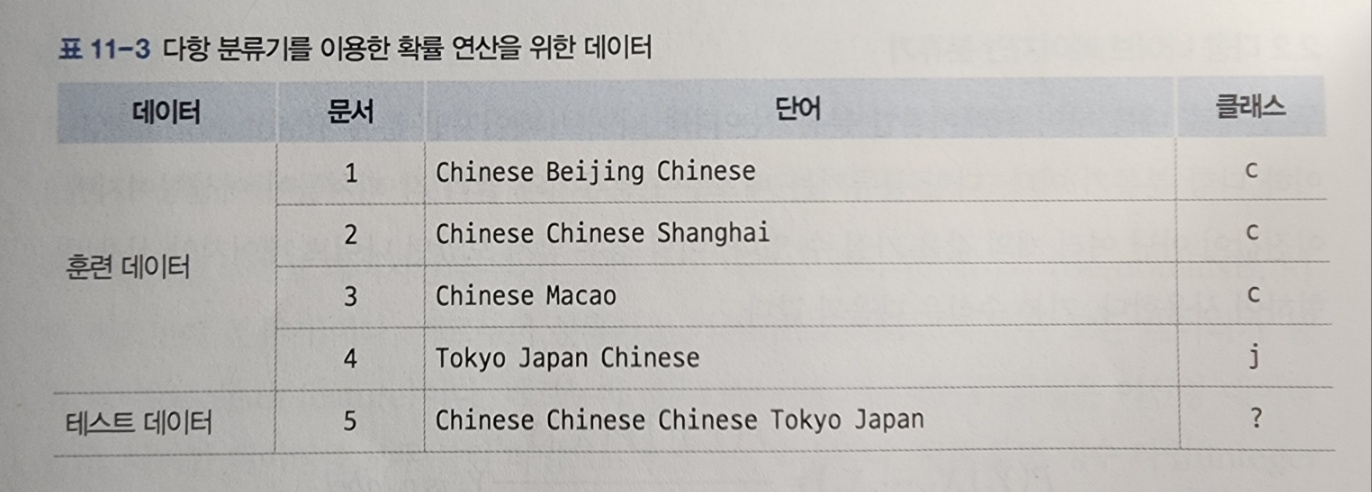

In [55]:
from IPython.display import Image
Image("C:/Machine_Learning (git)/chapter11/Naive Bayes Classifier Image 3.jpg")

- 이 상황에서 먼저 각 단어마다 가능도 계산(마지막 테스트 데이터 샘플을 예로 $P(Chinese|c)$ 계산)
    - $\frac{5 + 1}{8 + 6} = \frac{6}{14} = \frac{3}{7}$
        - 분모 8은 c 클래스에 해당하는 단어들의 총 개수
            - 문서 1 2 3이 모두 c 클래스이기 때문에 단어의 개수는 8개
        - 모든 단어종류의 개수를 구하면 6개
            - 스무딩 값은 1로 하여 연산하면 분모의 값 6이 나옴
        - 분자 5는 Chinese가 $Y_c$에 포함되는 개수인 5를 의미
        - 마지막으로 1은 스무딩 값
    - 각 클래스 별로 $\Pi_{i = 1}^n P(X_i|Y_c)$ 를 구해야 함
        - 마지막 테스트 데이터셋을 연산하기 위해 Chinese, Tokyo, Japan에 대한 c, j 클래스의 확률을 구해야 함
            - 즉 총 6개 항목에 대한 확률을 구한 후 같은 클래스끼리 더할 필요가 있음

- 내부적인 수식이 이와 같다면 사이킷런에서는 아래와 같이 코드를 작성
    - 다항 분류기는 베르누이 분류기보다 훨씬 간단하게 알파(alpha)만 정의하면 바로 사용 가능
    - 내부적인 구현이나 사용되는 방식은 다르겠지만 각 피쳐들이 이산형 값으로만 정의되어 있다면 매우 쉽게 사용 가능

In [56]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha = 1)
clf.fit(X_example, y_example)

MultinomialNB(alpha=1)

#### 2.3 가우시안 나이브 베이지안 분류기

- 가우시안 나이브 베이지안 분류기(GaussianNB, 이하 가우시안 분류기)
    - 이산형 데이터가 아닌 경우에 나이브 베이지안을 적용
    - 연속형 값을 피쳐로 가진 데이터의 확률을 구하기 위해 $y$의 분포를 정규분포(gaussian)로 가정
    - 이에 따라 확률밀도 함수 상의 해당 값 $x$가 나올 확률로 나이브 베이지안을 구현하여 사용
    - 가능도 값을 정의하면 다음과 같음
        - $P(x_i|Y_c) = \frac{1}{\sqrt{2\pi{\sigma_{Y_c}}^2}} exp(-\frac{(x_i - \mu Y_c)^2}{2{\sigma_{Y_c}}^2})$

- 만약 윗 부분 표와 같은 연속형 데이터가 있다면 아래 부분 표의 형태로 평균과 분산과 같은 통계수치를 계산

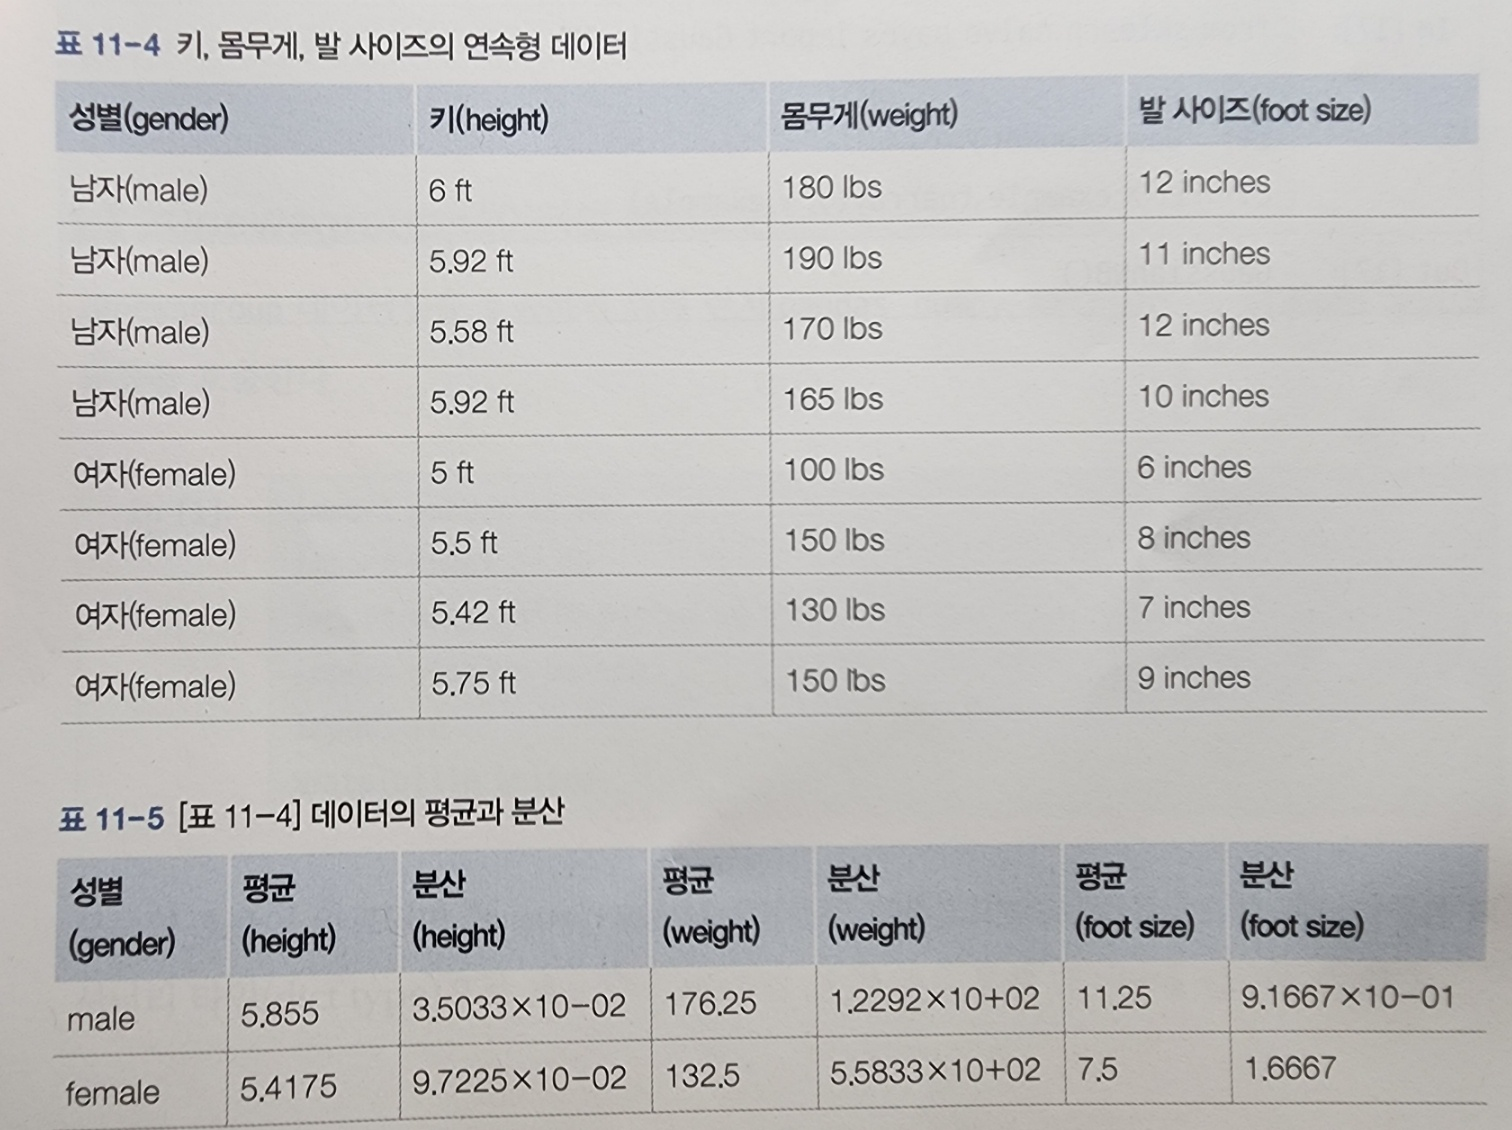

In [58]:
from IPython.display import Image
Image("c:/Machine_Learning (git)/chapter11/Naive Bayes Classifier Image 4.jpg")

- 위의 상태에서 새로운 값이 입력되면 다음 수식과 같이 성별이 남자인지 여자인지 구분할 수 있음
    - $postertior(male) = \frac{P(male)p(height|male)p(weight|male)p(foot size|male)}{evidence}$
    - $postertior(female) = \frac{P(female)p(height|female)p(weight|female)p(foot size|female)}{evidence}$

- 이를 모두 계산하면 원하는 값이 연속형 값일 경우에도 추출 가능
    - 중요한 점은 나이브 베이지안 연속형 값 $Y$를 계산하는 것은 아니고 이산형 값 $Y$에 대해 연속형 피쳐들을 처리할 수 있다는 점

- 가우시안 분류기 함수인 **GaussianNB**는 다음 코드와 같이 간단히 사용 가능
    - 실제로는 **priors, var_smoothing** 등의 값을 매개변수로 넣을 수 있음
        - 대부분의 경우 데이터를 기반으로 한 연산에서 나온 값을 그대로 사용하기 때문에 대부분의 경우 값을 넣지 않아도 잘 작동함


In [61]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_example.toarray(), y_example)

GaussianNB()